# Model point generation

In [1]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import approxbayescomp as abc
import numpy as np
import plotly.express as px
import numpy.random as rnd
from scipy.stats import gamma, norm
import math as ma
from rain import simulate_precipitation, simulate_precipitation_chat
# from loss_distribution import loss_distribution, cdf_X, quantile
from model_points import pmf_Sn, quantile_Sn, compute_Quantiles, CF_approximation, compute_stat_MP, compute_stat_Sn
import seaborn as sns
from tabulate import tabulate

# Load models data
CP_models = pd.read_csv('../../data/compound_poisson_models_pmom.csv')
CP_models = CP_models[CP_models['station'].isin(['MARSEILLE-MARIGNANE', 'STRASBOURG-ENTZHEIM'])]



/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Parameric insurance portfolio

A parametric insurance contract against heavy rain is characterized by an event date, a precipitation height threshold, a compensation and a location. 

- The event date $T$ is a day in year 2025, maybe an underwritting date $S$ such that $S<T$
- Precipitation heights are $\bar{Q} = 5$
- Compensations are nonnegative numbers $l\in\{5, 10, 15, 20\}$
- Locations are  Marseille, and Strasbourg

# Table 2

In [2]:
# Number of MP
n = 10
# Generate a list of all days in the year 2025
days_2024, days_2025 = pd.date_range(start='2024-01-01', end='2024-12-31').tolist(), pd.date_range(start='2025-01-01', end='2025-01-15').tolist()
Ss, Ts = np.random.choice(days_2024, n), np.random.choice(days_2025, n)
Qs, ls, stations = np.repeat(5, n), np.random.choice([5, 10, 15, 20], n), np.random.choice(np.unique(CP_models.station), n)
# # Data Frame that contain the parameric insurance portfolio
portfolio = pd.DataFrame({'S': Ss, 'T': Ts, 'Q': Qs, 'l': ls, 'station': stations})
portfolio.head()
# # Convert the first five rows of the portfolio dataframe to a LaTeX table
# portfolio['S'] = portfolio['S'].dt.date
# portfolio['T'] = portfolio['T'].dt.date
latex_table = tabulate(portfolio.head(), headers='keys', tablefmt='latex', showindex=False)
print(latex_table)

\begin{tabular}{llrrl}
\hline
 S                   & T                   &   Q &   l & station             \\
\hline
 2024-07-07 00:00:00 & 2025-01-05 00:00:00 &   5 &  15 & MARSEILLE-MARIGNANE \\
 2024-11-02 00:00:00 & 2025-01-09 00:00:00 &   5 &  10 & STRASBOURG-ENTZHEIM \\
 2024-02-17 00:00:00 & 2025-01-10 00:00:00 &   5 &  10 & STRASBOURG-ENTZHEIM \\
 2024-10-12 00:00:00 & 2025-01-06 00:00:00 &   5 &  15 & STRASBOURG-ENTZHEIM \\
 2024-08-22 00:00:00 & 2025-01-13 00:00:00 &   5 &  20 & STRASBOURG-ENTZHEIM \\
\hline
\end{tabular}


## Simulation study

In [3]:
pure_premium_list = []
for _, row in CP_models.iterrows():
    theta = row.lam, row.alpha, row.beta
    Q_sample = simulate_precipitation(theta, 10000)
    pure_premium_list.append(pd.DataFrame({
        'station': [row.station],
        'month': [row.month],
        'Q': [5],
        'P(A_T)': [np.mean(Q_sample > 5)]
    }))
pure_premium_df = pd.concat(pure_premium_list, ignore_index=True)


In [4]:
# Number of MP
n = 5
stations = np.unique(CP_models.station)


print(stations)
def generate_MPs(n):
    days_2025 = pd.date_range(start='2025-01-01', end='2025-12-31').tolist()
    chosen_combinations = np.random.choice(len(days_2025) * len(np.unique(CP_models.station)), n, replace=False)
    days_stations_combinations = [(days_2025[i // len(np.unique(CP_models.station))], np.unique(CP_models.station)[i % len(np.unique(CP_models.station))]) for i in chosen_combinations]
    n_contracts_per_MP = np.random.randint(low = 1, high = 10, size = n)
    Qs, ls = np.repeat(5, sum(n_contracts_per_MP)), np.random.choice([5, 10, 15, 20], sum(n_contracts_per_MP))
    Ts, stations = np.concatenate([np.repeat(days_stations_combinations[k][0], n_contracts_per_MP[k]) for k in range(n)]), np.concatenate([np.repeat(days_stations_combinations[k][1], n_contracts_per_MP[k]) for k in range(n)])

    portfolio = pd.DataFrame({'T': Ts, 'station': stations})

    portfolio["Q"] = Qs
    portfolio["l"] = ls
    safety_margin = 0.05

    portfolio['month'] = portfolio['T'].dt.month
    portfolio = portfolio.merge(pure_premium_df, on=['station', 'month', 'Q'], how='left')
    portfolio["pure_premium"] = portfolio["P(A_T)"] * portfolio["l"]
    portfolio["commercial_premium"] = portfolio["pure_premium"] * (1 + safety_margin)
    unique_combinations = portfolio[['T', 'station']].drop_duplicates()
    MPs = []
    for _, row in unique_combinations.iterrows():
        T, station = row['T'], row['station']
        subset_row = portfolio[(portfolio['T'] == T) & (portfolio['station'] == station)]
        grouped_row = subset_row.groupby(['P(A_T)', 'T', 'station'], as_index=False).agg({'l': 'sum'})
        grouped_row = grouped_row.sort_values(by='P(A_T)', ascending=False)
        grouped_row = pd.concat([pd.DataFrame({'P(A_T)': [1], 'l': [0], 'T': [T], 'station': [station]}), grouped_row], ignore_index=True)
        grouped_row['l'] = grouped_row['l'].cumsum()
        grouped_row['P(A_T)'] = grouped_row['P(A_T)'] - grouped_row['P(A_T)'].shift(-1, fill_value=0)
        S_Z = grouped_row['l'].to_numpy()
        p_Z = grouped_row['P(A_T)'].to_numpy()
        MPs.append({
            "MP#": len(MPs) + 1,
            "T": T,
            "station": station,
            "S_Z": S_Z,
            "p_Z": p_Z
        })
    return(MPs)

generate_MPs(n)


['MARSEILLE-MARIGNANE' 'STRASBOURG-ENTZHEIM']


[{'MP#': 1,
  'T': Timestamp('2025-11-09 00:00:00'),
  'station': 'STRASBOURG-ENTZHEIM',
  'S_Z': array([ 0, 60]),
  'p_Z': array([0.892, 0.108])},
 {'MP#': 2,
  'T': Timestamp('2025-04-03 00:00:00'),
  'station': 'STRASBOURG-ENTZHEIM',
  'S_Z': array([ 0, 25]),
  'p_Z': array([0.8986, 0.1014])},
 {'MP#': 3,
  'T': Timestamp('2025-02-28 00:00:00'),
  'station': 'MARSEILLE-MARIGNANE',
  'S_Z': array([ 0, 80]),
  'p_Z': array([0.9266, 0.0734])},
 {'MP#': 4,
  'T': Timestamp('2025-11-01 00:00:00'),
  'station': 'MARSEILLE-MARIGNANE',
  'S_Z': array([ 0, 90]),
  'p_Z': array([0.8553, 0.1447])},
 {'MP#': 5,
  'T': Timestamp('2025-02-07 00:00:00'),
  'station': 'STRASBOURG-ENTZHEIM',
  'S_Z': array([ 0, 40]),
  'p_Z': array([0.9261, 0.0739])}]

In [8]:
# n, alphas = 100, [0.85, 0.995]
# Q_dfs = []

# for run in range(1, 100):
#     print(run)
#     MPs = generate_MPs(n)
#     Q_df = pd.concat([compute_Quantiles(MPs[0:i+1], alphas) for i in range(2, n)], ignore_index = True)
#     Q_df["run"] = run

#     Q_dfs.append(Q_df)
# Q_df_final = pd.concat(Q_dfs, ignore_index = True)
# Q_df_final

In [6]:
# Q_df_final.to_csv('Q_df_final.csv', index=False)
# Load the saved CSV file into a DataFrame
Q_df_final = pd.read_csv('Q_df_final.csv')
print(Q_df_final.head())

       Q0.85      Q0.995 method  diff_Q0.85  diff_Q0.995  n  run
0  46.408137   96.418529   CF_1    2.093876    -0.196512  3    1
1  47.417707  173.093322   CF_2    2.161180     0.442444  3    1
2  59.986101   71.746933   CF_3    2.999073    -0.402109  3    1
3  15.000000  120.000000    FFT    0.000000     0.000000  3    1
4  56.403245  112.722534   CF_1    0.025514    -0.295484  4    1


/var/folders/8h/lgkzf9js64d06g8jj9f2nhnw0000gn/T/ipykernel_73184/393460288.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['method'] = subset_df['method'].replace({


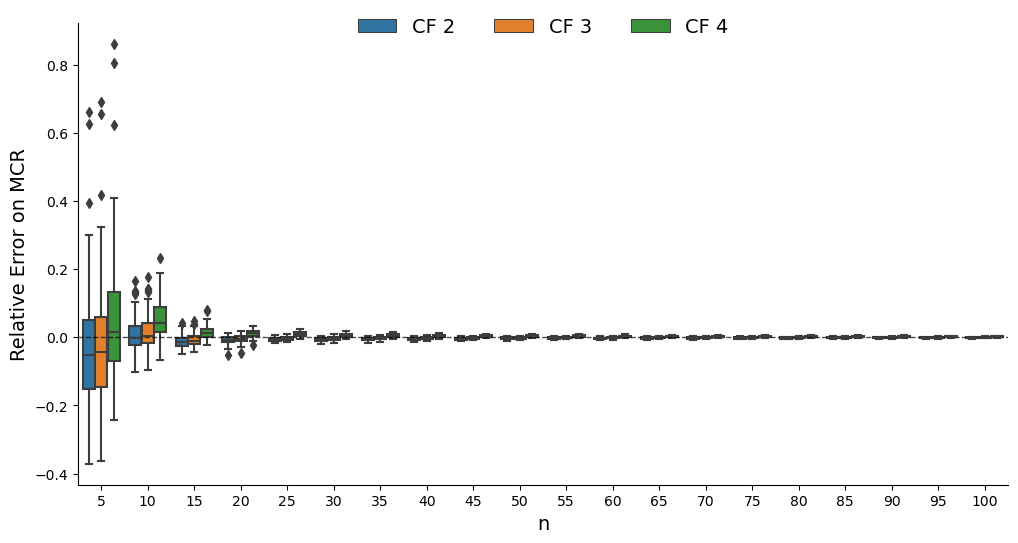

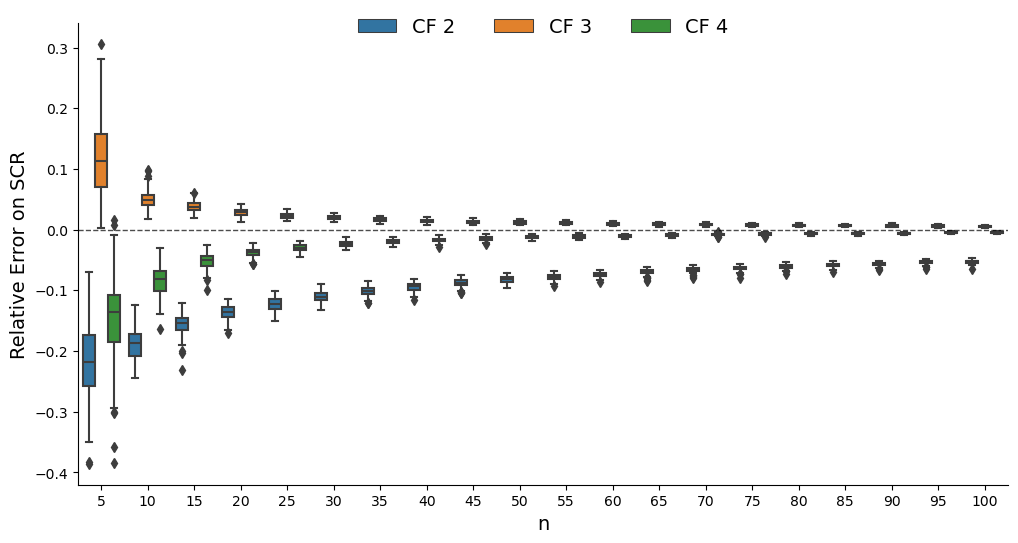

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_df = Q_df_final[Q_df_final['method'] != 'FFT']

# Melt the dataframe to have diff_Q variables in a single column for easier plotting
melted_df = filtered_df.melt(id_vars=['n', 'method'], 
                             value_vars=['diff_Q0.85','diff_Q0.995'], 
                             var_name='diff_Q', 
                             value_name='value')

                            # Subset the data for n equal to 0 modulo 5
subset_df = melted_df[melted_df['n'] % 5 == 0]


# Update method labels for better readability
subset_df['method'] = subset_df['method'].replace({
    'CF_1': 'CF 2',
    'CF_2': 'CF 3',
    'CF_3': 'CF 4'
})
# Save the plots as PDF files
for diff_q, label, filename in zip(['diff_Q0.85', 'diff_Q0.995'], ['MCR', 'SCR'], ['../../figures/relative_error_MCR.pdf', '../../figures/relative_error_SCR.pdf']):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=subset_df[subset_df['diff_Q'] == diff_q], x='n', y='value', hue='method')
    plt.xlabel('n', fontsize=14)
    plt.ylabel(f'Relative Error on {label}', fontsize=14)
    plt.legend(loc='upper center', fontsize=14, frameon=False, bbox_to_anchor=(0.5, 1.05), ncol=len(subset_df['method'].unique()))
    plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
    sns.despine()
    
    plt.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close()

